In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude
from craterdetection.matching.database import extract_robbins_dataset, load_craters
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[3, 30], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [15]:
# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 300

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt)

cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', -20, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.5)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(scale_det(C_craters), r_craters)

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:22: UserWarning: No contour levels were found within the data range.


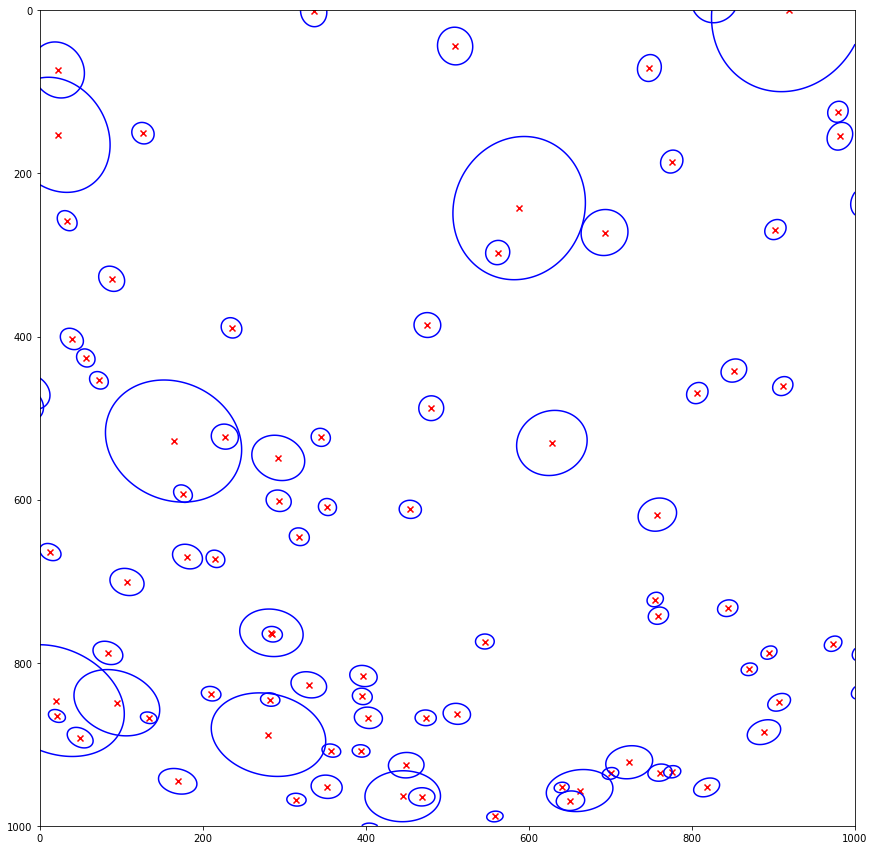

In [28]:
x_plot = np.linspace(0, cam.resolution[0], 1000)
y_plot = np.linspace(0, cam.resolution[1], 1000)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, cam.resolution[0])
ax.set_ylim(cam.resolution[1], 0)

for a_i in A_craters:
    c = xy_homogeneous.transpose(0, 2, 1) @ scale_det(a_i) @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='b')
ax.scatter(*(LA.inv(A_craters[:, :2, :2]) @ -A_craters[:, :2, 2][..., None])[..., 0].T, c='r', marker='x')

In [22]:
%%time
major, minor = ellipse_axes(scale_det(A_craters))
psi = ellipse_angle(scale_det(A_craters))
r_pix = conic_center(scale_det(A_craters))

Wall time: 1 ms


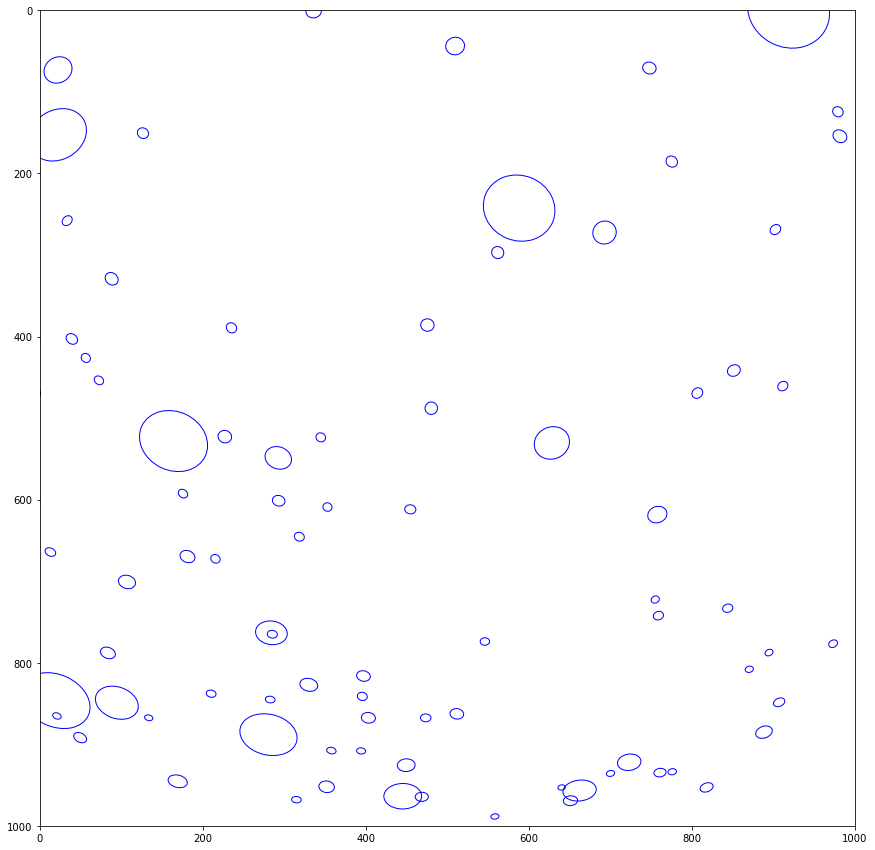

In [33]:
from matplotlib.collections import EllipseCollection
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})

ec = EllipseCollection(major, minor, np.degrees(psi), units='xy', offsets=r_pix,
                       transOffset=ax.transData, facecolors="None", edgecolors='b')
ax.add_collection(ec)
ax.set_xlim(0, cam.resolution[0])
ax.set_ylim(cam.resolution[1], 0)
plt.show()